In [ ]:
EPOCHS = 10
PATH_RES = 'cnn_results'

# **CIFAR-10 Image Classification with Convolutional Neural Networks**

## Dataset Overview
The CIFAR-10 dataset is a widely used benchmark in computer vision and deep learning research, consisting of 60,000 color images distributed across 10 distinct classes. Each image has dimensions of 32×32 pixels with RGB channels, making it ideal for convolutional neural network training due to its manageable size and complexity.

## Class Distribution
The dataset contains exactly 6,000 images per class, organized into the following categories:
- **Airplane** ✈️
- **Automobile** 🚗
- **Bird** 🐦
- **Cat** 🐱
- **Deer** 🦌
- **Dog** 🐕
- **Frog** 🐸
- **Horse** 🐎
- **Ship** 🚢
- **Truck** 🚚

Imports

In [103]:

import os
import random
import time
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from datasets import load_dataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### set seed for reproducibility

In [105]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


###  Visualization Helpers
 Defines plotting functions for training/validation loss, confusion matrix, and feature map visualization.

In [106]:
def plot_loss(train_losses, val_losses, out_path=None):
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    if out_path:
        plt.savefig(out_path, bbox_inches='tight')
    plt.close()


def plot_confusion_matrix(cm, classes, out_path=None):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, bbox_inches='tight')
    plt.close()


def visualize_feature_maps(model, img_tensor, layer_indices=[0,2,4], save_dir=None):
    """Extract and plot feature maps for selected convolutional layers.
    layer_indices are indices inside model.features sequential module.
    img_tensor: (1,3,32,32)
    """
    model.eval()
    img_tensor = img_tensor.to(device)
    activations = {}
    x = img_tensor
    for idx, layer in enumerate(model.features):
        x = layer(x)
        if idx in layer_indices:
            activations[idx] = x.detach().cpu()
    # Plot first 8 feature maps of each selected layer
    for k, act in activations.items():
        num_maps = min(8, act.shape[1])
        fig, axes = plt.subplots(1, num_maps, figsize=(num_maps*2,2))
        for i in range(num_maps):
            ax = axes[i]
            fmap = act[0,i].numpy()
            ax.imshow(fmap, cmap='gray')
            ax.axis('off')
        plt.suptitle(f'Layer {k} feature maps')
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f'feature_maps_layer_{k}.png'), bbox_inches='tight')
        plt.show(fig)
        plt.close(fig)


### Dataset Preparation
Load the CIFAR-10 dataset from Hugging Face and Preprocess the images

## Custom Dataset Class
**Parameters:** hf_dataset (Hugging Face dataset), transform (composed transforms)

**Returns:** PyTorch Dataset object compatible with DataLoader
Wraps the Hugging Face CIFAR-10 dataset to provide PyTorch compatibility with proper image transformation support and label handling.

In [107]:
class CIFAR10TorchDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = item['img']  # PIL Image provided by HF dataset
        label = int(item['label'])
        if self.transform:
            img = self.transform(img)
        return img, label


## Transform Functions
**Returns:** Two transform compositions (transform_train, transform_test)
Defines separate transformation pipelines:

- **Training:** Includes data augmentation (RandomHorizontalFlip) plus ToTensor conversion and CIFAR-10 specific normalization

- **Testing:** Only includes conversion and normalization (no augmentation)
Uses standard CIFAR-10 mean and std values for normalization.

In [108]:
def transform_dataset():
		# Transforms
	transform_train = transforms.Compose([
		# augments training images
		transforms.RandomHorizontalFlip(),
		# converts PIL → PyTorch tensor
		transforms.ToTensor(),
		transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
	])
	transform_test = transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
	])
	return transform_train,transform_test

In [109]:
def show_sample(hf):

	sample = hf['train'][0]
	img_pil = sample['img']
	label_idx = sample['label']
	class_names = hf['train'].features['label'].names

	plt.figure(figsize=(3,3))
	plt.imshow(img_pil)
	plt.title(f"raw HF img, label: {class_names[label_idx]}")
	plt.axis('off')
	plt.show()

## DataLoader Creation
**Parameters:** batch_size (default=64) - number of samples per batch

**Returns:** train_loader, test_loader, test_ds (DataLoader objects and test dataset)
Loads CIFAR-10 from Hugging Face, applies appropriate transforms, and creates PyTorch DataLoaders with training data shuffled and both loaders using the specified batch size.

In [110]:
def get_dataloaders(batch_size=64):
    # Load all transformers
    transform_train, transform_test = transform_dataset()

    # Load dataset
    ds = load_dataset("cifar10")

    train_ds = CIFAR10TorchDataset(ds["train"], transform=transform_train)
    test_ds = CIFAR10TorchDataset(ds["test"], transform=transform_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader, test_ds


### Build a Convolutional Neural Network
Using a deep learning framework and train the model. Plot training error against each epoch

## Training Function
**Parameters:** model (CNN model), loader (DataLoader), criterion (loss function), optimizer

**Returns:** Average training loss for the epoch
Implements one epoch of training: sets model to train mode, iterates through batches, performs forward pass, computes loss, backpropagates, and updates weights. Returns average loss across all batches.

In [111]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
         # clears grad for each batch
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)


## Evaluation Function
**Parameters:** model (CNN model), loader (DataLoader), criterion (loss function)

**Returns:** avg_loss (average loss), preds (model predictions), targets (true labels)
Evaluates model performance: sets model to eval mode, disables gradient computation, computes loss, collects predictions and true labels for metric calculation. Returns comprehensive evaluation results.

In [112]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    preds = []
    targets = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            # get predicted class with highest logit
            _, predicted = torch.max(outputs, 1)
            # save prediction
            preds.extend(predicted.cpu().numpy().tolist())
            targets.extend(labels.cpu().numpy().tolist())
    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, np.array(preds), np.array(targets)


## CNN Model Definition
**Parameters:** num_classes (default=10), conv_filters (filter sizes per layer), num_conv_blocks (number of conv layers), dropout (regularization rate)

**Returns:** SimpleCNN model instance
Defines a configurable CNN architecture with:
- Multiple convolutional blocks (Conv2d + BatchNorm + ReLU)
- Adaptive max pooling that maintains spatial dimensions
- Classifier with flattening, fully connected layers, and dropout
- Automatic calculation of flattened feature size

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, conv_filters=[32, 64, 128], num_conv_blocks=3, dropout=0.3):
        super().__init__()
        layers = []
        in_ch = 3
        # start from CIFAR10 image size
        spatial_size = 32

        for i in range(num_conv_blocks):
            # conv-filters = # of filters applied each layer
            out_ch = conv_filters[i] if i < len(conv_filters) else conv_filters[-1]
            layers += [
                # padding = 1 -> image size remains the same after conv
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            ]
            # only add pooling if size will remain >= 1
            if (spatial_size // 2) >= 1:
                layers.append(nn.MaxPool2d(2))
                spatial_size //= 2
            in_ch = out_ch

        # apply layers sequentially
        self.features = nn.Sequential(*layers)

        # now spatial_size tracks the correct size
        self.classifier = nn.Sequential(
            # final 3D tensor (channels × H × W) -> flat 1D vector
            nn.Flatten(),
            # output layer (256 probs)
            nn.Linear(in_ch * spatial_size * spatial_size, 256),
            nn.ReLU(inplace=True),
            # drop activations, prevetn overfitting
            nn.Dropout(dropout),
            # mapping to 10 output classes
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x -> batch of (3,32,32) images
        # apply layers for extraction to batch
        x = self.features(x)
        # flattened, output = (batchsize, 10) prob of each class per sample
        x = self.classifier(x)
        return x


## Run System
**Parameters:** train_loader, test_loader, test_ds, save_dir, num_epochs, lr, conv_filters, num_conv_blocks, seed

**Function:** Complete training pipeline including:
- Model initialization and training setup
- Epoch-wise training and validation
- Best model saving based on validation loss
- Loss curve plotting
- Final evaluation with metric calculation (accuracy, precision, recall, F1)
- Confusion matrix visualization
- Feature map extraction and visualization
Saves all results to specified directory.

In [114]:
def run_experiment(train_loader,
                   test_loader,
                   test_ds,
                   save_dir='results',
                   num_epochs=20,
                   lr=0.001,
                   conv_filters=[32,64,128],
                   num_conv_blocks=3,
                   seed=42):

    set_seed(seed)
    os.makedirs(save_dir, exist_ok=True)

    # Build model + training setup
    model = SimpleCNN(num_classes=10, conv_filters=conv_filters, num_conv_blocks=num_conv_blocks).to(device)
    # softmax + -ve log-likelihood
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs+1):
        t0 = time.time()
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, _, _ = evaluate(model, test_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch}/{num_epochs} - train_loss: {train_loss:.4f} val_loss: {val_loss:.4f} time: {time.time()-t0:.1f}s')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))

    # Plotting losses
    fig = plot_loss(train_losses, val_losses, out_path=os.path.join(save_dir, 'loss.png'))
    plt.show(fig)
    plt.close(fig)

    # Final evaluation
    model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pth')))
    _, preds, targets = evaluate(model, test_loader, criterion)

    # Metrics
    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average='macro', zero_division=0)
    recall = recall_score(targets, preds, average='macro', zero_division=0)
    f1 = f1_score(targets, preds, average='macro', zero_division=0)

    cm = confusion_matrix(targets, preds)
    fig = plot_confusion_matrix(cm, classes=[str(i) for i in range(10)],
                                out_path=os.path.join(save_dir, 'confusion_matrix.png'))
    plt.show(fig)
    plt.close(fig)

    metrics = {
              'accuracy': accuracy,
              'precision': precision,
              'recall': recall,
              'f1': f1
              }
    pd.DataFrame([metrics]).to_csv(os.path.join(save_dir, 'metrics.csv'), index=False)

    # Feature maps
    sample_img, _ = test_ds[0]
    visualize_feature_maps(model, sample_img.unsqueeze(0), layer_indices=[0,2,4], save_dir=save_dir)
    return metrics


In [115]:
def ablation_study(train_loader, test_loader, test_ds, out_dir='ablation_results'):
    os.makedirs(out_dir, exist_ok=True)
    experiments = []

    # Baseline
    baseline = dict(lr=0.001, batch_size=64, conv_filters=[32,64,128], num_conv_blocks=3)

    # Learning rates
    for lr in [0.001, 0.01, 0.1]:
        name = f'lr_{lr}'
        save_dir = os.path.join(out_dir, name)
        print(f"\n=== Running experiment: {name} ===")
        print(f"Params -> lr: {lr}, batch_size: {baseline['batch_size']}, "
              f"filters: {baseline['conv_filters']}, layers: {baseline['num_conv_blocks']}")

        metrics = run_experiment(train_loader, test_loader, test_ds,
                                 save_dir=save_dir, lr=lr,
                                 conv_filters=baseline['conv_filters'],
                                 num_conv_blocks=baseline['num_conv_blocks'],
                                 num_epochs=EPOCHS)

        print(f"Results -> Acc: {metrics['accuracy']:.4f}, Prec: {metrics['precision']:.4f}, "
              f"Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

        experiments.append((name, lr, baseline['batch_size'], baseline['conv_filters'],
                            baseline['num_conv_blocks'], metrics))

    # Batch sizes
    for bs in [16, 32, 64]:
        name = f'bs_{bs}'
        save_dir = os.path.join(out_dir, name)
        print(f"\n=== Running experiment: {name} ===")
        print(f"Params -> lr: {baseline['lr']}, batch_size: {bs}, "
              f"filters: {baseline['conv_filters']}, layers: {baseline['num_conv_blocks']}")

        train_loader_bs, test_loader_bs, _ = get_dataloaders(batch_size=bs)
        metrics = run_experiment(train_loader_bs, test_loader_bs, test_ds,
                                 save_dir=save_dir, lr=baseline['lr'],
                                 conv_filters=baseline['conv_filters'],
                                 num_conv_blocks=baseline['num_conv_blocks'],
                                 num_epochs=EPOCHS)

        print(f"Results -> Acc: {metrics['accuracy']:.4f}, Prec: {metrics['precision']:.4f}, "
              f"Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

        experiments.append((name, baseline['lr'], bs, baseline['conv_filters'],
                            baseline['num_conv_blocks'], metrics))

    # Filters
    for f in [16, 32, 64]:
        conv_filters = [f, f*2, f*4]
        name = f'filters_{f}'
        save_dir = os.path.join(out_dir, name)
        print(f"\n=== Running experiment: {name} ===")
        print(f"Params -> lr: {baseline['lr']}, batch_size: {baseline['batch_size']}, "
              f"filters: {conv_filters}, layers: {baseline['num_conv_blocks']}")

        metrics = run_experiment(train_loader, test_loader, test_ds,
                                 save_dir=save_dir, lr=baseline['lr'],
                                 conv_filters=conv_filters,
                                 num_conv_blocks=baseline['num_conv_blocks'],
                                 num_epochs=EPOCHS)

        print(f"Results -> Acc: {metrics['accuracy']:.4f}, Prec: {metrics['precision']:.4f}, "
              f"Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

        experiments.append((name, baseline['lr'], baseline['batch_size'],
                            conv_filters, baseline['num_conv_blocks'], metrics))

    # Number of conv layers
    for layers in [3, 5, 7]:
        base = 32
        conv_filters = [base*(2**i) for i in range(layers)]
        name = f'layers_{layers}'
        save_dir = os.path.join(out_dir, name)
        print(f"\n=== Running experiment: {name} ===")
        print(f"Params -> lr: {baseline['lr']}, batch_size: {baseline['batch_size']}, "
              f"filters: {conv_filters}, layers: {layers}")

        metrics = run_experiment(train_loader, test_loader, test_ds,
                                 save_dir=save_dir, lr=baseline['lr'],
                                 conv_filters=conv_filters,
                                 num_conv_blocks=layers,
                                 num_epochs=EPOCHS)

        print(f"Results -> Acc: {metrics['accuracy']:.4f}, Prec: {metrics['precision']:.4f}, "
              f"Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

        experiments.append((name, baseline['lr'], baseline['batch_size'],
                            conv_filters, layers, metrics))

    # Save summary table
    rows = []
    for e in experiments:
        name, lr, bs, conv_filters, layers, metrics = e
        rows.append({
            'exp': name,
            'lr': lr,
            'batch_size': bs,
            'filters': str(conv_filters),
            'layers': layers,
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1': metrics['f1']
        })
    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(out_dir, 'ablation_summary.csv'), index=False)
    print('\nAblation study complete. Summary saved to', os.path.join(out_dir, 'ablation_summary.csv'))
    return df


Epoch 1/30 - train_loss: 1.2979 val_loss: 0.9353 time: 69.1s
Epoch 2/30 - train_loss: 0.9363 val_loss: 0.7945 time: 67.9s
Epoch 3/30 - train_loss: 0.8025 val_loss: 0.7377 time: 67.6s
Epoch 4/30 - train_loss: 0.7075 val_loss: 0.6628 time: 66.1s
Epoch 5/30 - train_loss: 0.6376 val_loss: 0.6423 time: 66.6s
Epoch 6/30 - train_loss: 0.5746 val_loss: 0.5834 time: 65.8s
Epoch 7/30 - train_loss: 0.5286 val_loss: 0.5920 time: 65.4s
Epoch 8/30 - train_loss: 0.4898 val_loss: 0.5993 time: 65.5s
Epoch 9/30 - train_loss: 0.4528 val_loss: 0.5406 time: 69.7s
Epoch 10/30 - train_loss: 0.4116 val_loss: 0.5597 time: 68.0s
Epoch 11/30 - train_loss: 0.3850 val_loss: 0.5425 time: 69.6s
Epoch 12/30 - train_loss: 0.3523 val_loss: 0.5544 time: 74.0s
Epoch 13/30 - train_loss: 0.3302 val_loss: 0.5432 time: 72.3s
Epoch 14/30 - train_loss: 0.3081 val_loss: 0.5893 time: 69.7s
Epoch 15/30 - train_loss: 0.2849 val_loss: 0.5893 time: 69.0s
Epoch 16/30 - train_loss: 0.2615 val_loss: 0.5528 time: 66.8s
Epoch 17/30 - tra

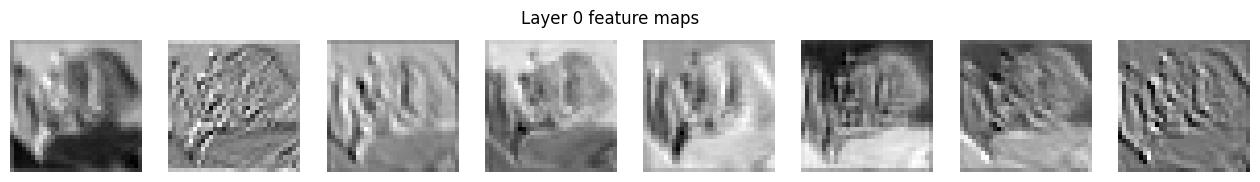

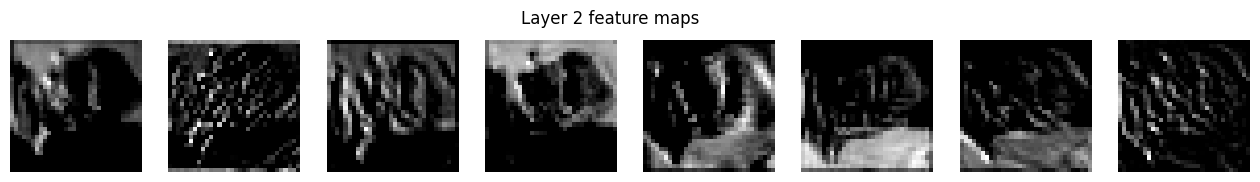

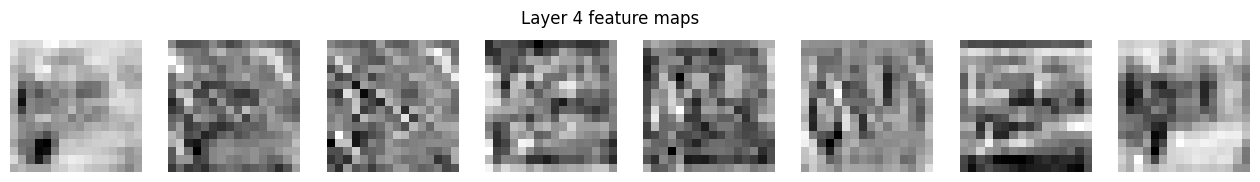

In [ ]:
class Args:
    mode = 'ablation'
    # mode = 'run'
    out = PATH_RES
    epochs = EPOCHS
    lr = 0.01
    batch = 16
    filters = '64,128,256'
    layers = 7

args = Args()
filters = [int(x) for x in args.filters.split(',')]

# Load dataset once at start
train_loader, test_loader, test_ds = get_dataloaders(batch_size=args.batch)

if args.mode == 'run':
    run_experiment(train_loader, test_loader, test_ds,
                   save_dir=args.out,
                   num_epochs=args.epochs,
                   lr=args.lr,
                   conv_filters=filters,
                   num_conv_blocks=args.layers)
else:
    ablation_study(train_loader, test_loader, test_ds, out_dir=args.out)
